In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.26, Omega_b = 0.04, h = 0.7, sigma8 = 0.8, n_s = 0.96, matter_power_spectrum='linear')
h     = cosmo.cosmo.params.h

#Config params. Can change as you need. I store these as a dict and then unpack.
bpar_S19 = dict(theta_ej = 4, theta_co = 0.1, M_c = 1e14/h, mu_beta = 0.4,
                eta = 0.3, eta_delta = 0.3, tau = -1.5, tau_delta = 0, #Must use tau here since we go down to low mass
                A = 0.09/2, M1 = 2.5e11/h, epsilon_h = 0.015, 
                a = 0.3, n = 2, epsilon = 4, p = 0.3, q = 0.707, gamma = 2, delta = 7)

bpar_A20 = dict(alpha_g = 2, epsilon_h = 0.015, M1_0 = 2.2e11/h, 
                alpha_fsat = 1, M1_fsat = 1, delta_fsat = 1, gamma_fsat = 1, eps_fsat = 1,
                M_c = 1.2e14/h, eta = 0.6, mu = 0.31, beta = 0.6, epsilon_hydro = np.sqrt(5),
                M_inn = 3.3e13/h, M_r = 1e16, beta_r = 2, theta_inn = 0.1, theta_out = 3,
                theta_rg = 0.3, sigma_rg = 0.1, a = 0.3, n = 2, p = 0.3, q = 0.707,
                A_nt = 0.495, alpha_nt = 0.1,
                mean_molecular_weight = 0.59)

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

# SETUP

In [3]:
#Dictionaries to store all our results so we can plot them all at the end
#One for matter-matter response, and one for matter-pressure response
R_mm = {}
R_mp = {} 

a    = 1 #Compute everything at z = 0
k    = np.geomspace(1e-3, 20, 100) #Compute across a wide range in k [1/Mpc, comoving]
rho  = ccl.rho_x(cosmo, a, 'matter', is_comoving = True)


#We will use the built-in, CCL halo model calculation tools.
HMC  = ccl.halos.halo_model.HMCalculator(mass_function = 'Tinker08', halo_bias = 'Tinker10', 
                                         mass_def = ccl.halos.massdef.MassDef200c, 
                                         log10M_min = 9, log10M_max = 16, nM = 100)


fft_precision = dict(padding_lo_fftlog = 1e-8, padding_hi_fftlog = 1e8, n_per_decade = 100)

# Compute Mead models

In [4]:
par = bfg.Profiles.Mead20.Params_TAGN_7p8_MPr

#Define profiles. Normalize to convert density --> overdensity
DMB = bfg.Profiles.Mead20.DarkMatterBaryon(**par) / rho
DMO = bfg.Profiles.Mead20.DarkMatter(**par) / rho
PRS = bfg.Profiles.Mead20.Pressure(**par)

#Upgrade precision of all profiles.
for p in [DMB, DMO, PRS]: p.update_precision_fftlog(**fft_precision)

In [5]:
#Compute all power spectra. This routine has some functionality to mimic the
#transition-regime modelling of Mead++ in HMCode. We only use the suppression term,
#though you could also use the explicit transition scaling, alpha, as well.
P_mm_dmo = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMO, suppress_1h = lambda k : 1e-2)
P_mm_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB, suppress_1h = lambda k : 1e-2)
P_mp_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB, prof2 = PRS, suppress_1h = lambda k : 1e-2)

#Store the halo model response
R_mm['Mead20'] = P_mm_bar/P_mm_dmo
R_mp['Mead20'] = P_mp_bar/P_mm_dmo

#Extract linear P(k) for comparison
P_mm_lin = ccl.linear_matter_power(cosmo, k, a)

In [6]:
%%timeit
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB)
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB, prof2 = PRS)

1.66 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


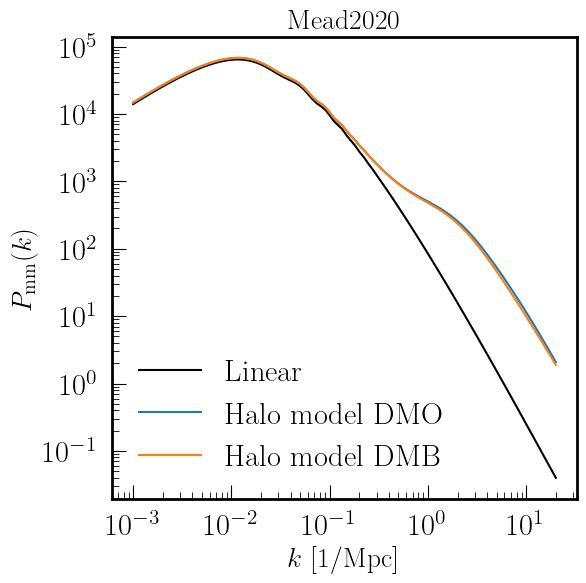

In [7]:
plt.figure(figsize = (6,6))
plt.loglog()

plt.plot(k, P_mm_lin, color = 'k', label = 'Linear')
plt.plot(k, P_mm_dmo, label = 'Halo model DMO')
plt.plot(k, P_mm_bar, label = 'Halo model DMB')

plt.xlabel(r'$k$ [1/Mpc]', size = 20)
plt.ylabel(r'$P_{\rm mm}(k)$', size = 20)
plt.title(r'Mead2020', size = 20)
plt.tick_params(pad = 10)
plt.legend()
plt.show()

# Now do the same for Schneider19

In [8]:
par = bpar_S19

#The r_min_int, r_max_int, and r_steps control the grid used to do numerical integrals in the code.
#Most integrals are for computing the mass of a given component at M(r --> \infty) as this is how
#the S19 models are normalized. For the CLM profiles, we also use this grid to do the relaxation.
DMO = bfg.Profiles.Schneider19.DarkMatter(**bpar_S19, r_min_int = 1e-3, r_max_int = 1e2, r_steps = 500)
GAS = bfg.Profiles.Schneider19.Gas(**bpar_S19, r_min_int = 1e-3, r_max_int = 1e2, r_steps = 500)
STR = bfg.Profiles.Schneider19.Stars(**bpar_S19, r_min_int = 1e-6, r_max_int = 5, r_steps = 500)
CLM = bfg.Profiles.Schneider19.CollisionlessMatter(**bpar_S19, max_iter = 2, reltol = 5e-2, r_steps = 500)

#Normally the DMB profile has the two-halo piece in it, but let's remove that here since
#we are doing a halo model calculation. We remove by passing a "zero" profile to it.
#There is negligible computational overhead from removing the 2-halo term this way.
DMB = bfg.Profiles.Schneider19.DarkMatterBaryon(**bpar_S19, 
                                                gas = GAS, stars = STR, 
                                                collisionlessmatter = CLM, darkmatter = DMO,
                                                twohalo = bfg.Profiles.misc.Zeros(),
                                                r_steps = 500)

PRS = bfg.Profiles.Pressure(gas = GAS, darkmatterbaryon = DMB, **bpar_S19, r_min_int = 1e-4, r_max_int = 1e2, r_steps = 500)

#A function that gives us the M(r --> infty) mass of a given halo.
#We can use just the DMO profiles for this, since the DMB is renormalized to
#give the same total mass as DMO. This function is needed to get the right
#large-scale behavior of the P(k) while using CCL routines.
M_2_Mtot = bfg.Profiles.misc.Mdelta_to_Mtot(DMO, r_min = 1e-6, r_max = 1e2, N_int = 100)

#Now convert density --> overdensity
#We do this later because PRS is defined with density
DMB = DMB / rho
DMO = DMO / rho

#Just example of how to do truncation. But below we
#do no truncation since radius is R_t = R200c * 100
#You could lower it if you want. But that will cause
#M_DMO(infty) != M_DMB(infty) which is important for baryonification
#Once defined, you can just compose the profiles easily to apply truncation
T   = bfg.Profiles.misc.Truncation(epsilon = 100)
DMB = DMB * T
DMO = DMO * T

#Upgrade precision of all profiles.
for p in [DMB, DMO, PRS]: p.update_precision_fftlog(**fft_precision)

In [9]:
#We need to construct an alternative halo model estimator. This is because the CCL HMcalculator makes the
#(very reasonable) assumption that a halo of M200c has a density profile that when integrated 
#to infinity, gives M200c. This is true for Mead2020 and Arico2020, but not Schneider19.
#So the FlexibleHMCalculator below gets around this by using a function Mtot(M200c) to map from M200c
#to the total mass of the halo (given by the M_2_Mtot object here and more generally by the class
#bfg.Profiles.misc.Mdelta_to_Mtot). This is needed only for the Schneider model. If you don't do this
#then you don't respect the physical expectation of P_2h(k-->0) = P_lin(k-->0)
HMC_flex = bfg.utils.FlexibleHMCalculator(mass_function = 'Tinker08', halo_bias = 'Tinker10', halo_m_to_mtot = M_2_Mtot,
                                          mass_def = ccl.halos.massdef.MassDef200c, 
                                          log10M_min = 9, log10M_max = 16, nM = 100)

#Compute all power spectra 
P_mm_dmo = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC_flex, k, a, DMO, suppress_1h = lambda k : 1e-2)
P_mm_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC_flex, k, a, DMB, suppress_1h = lambda k : 1e-2)
P_mp_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC_flex, k, a, DMB, prof2 = PRS, suppress_1h = lambda k : 1e-2)

#Store the halo model response
R_mm['Schneider19'] = P_mm_bar/P_mm_dmo
R_mp['Schneider19'] = P_mp_bar/P_mm_dmo

#Extract linear P(k) for comparison
P_mm_lin = ccl.linear_matter_power(cosmo, k, a)

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:972: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (1.0000000000000001e-11)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:974: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (2000000000.0)
  warnings.warn(f"Increase integral upper limit, r_max_int ({self.r_max_int}) < maximum radius ({np.max(r)})", UserWarning)


In [10]:
%%timeit
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC_flex, k, a, DMB)
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC_flex, k, a, DMB, prof2 = PRS)

5.7 s ± 283 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


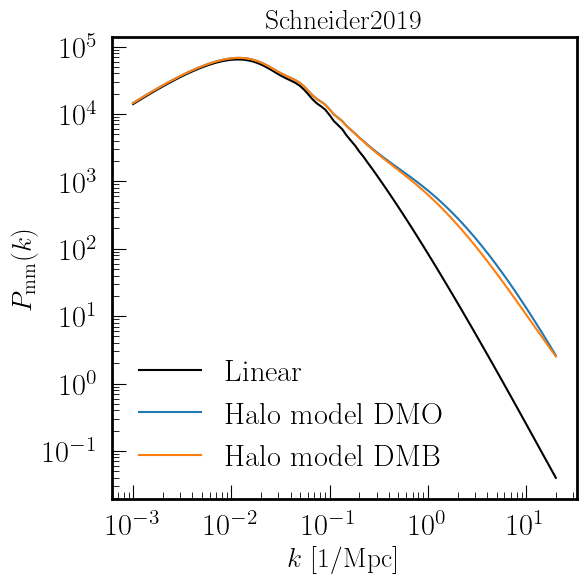

In [11]:
plt.figure(figsize = (6,6))
plt.loglog()

#The DMO and BAR P(k) are higher than the linear ones. This is because the Schneider Profiles
#extend well beyond R200c, so halo exclusion is an even bigger issues for their formalism, and
#there will be a lot of double-counting of matter, leading to a higher-bias-than-necessary.
#You could control this by truncating the profiles, but that will cause mismatch of P(k-->0)
#between DMO and DMB versions, since M_DMO(r >> R200c) != M_DMB(r >> R200c) anymore.
plt.plot(k, P_mm_lin, color = 'k', label = 'Linear')
plt.plot(k, P_mm_dmo, label = 'Halo model DMO')
plt.plot(k, P_mm_bar, label = 'Halo model DMB')

plt.xlabel(r'$k$ [1/Mpc]', size = 20)
plt.ylabel(r'$P_{\rm mm}(k)$', size = 20)
plt.title(r'Schneider2019', size = 20)
plt.tick_params(pad = 10)
plt.legend()
plt.show()

# Now do the same for Arico20

In [12]:
par = bpar_A20

#There's a TBD on the Arico Gas profile truncation. The Arico model
#truncates profiles at R200c (except for ejected gas) but that is
#not what is found in fig 2 of https://arxiv.org/pdf/2406.01672v1
#so I need to sort out the details still. For now, we apply truncation
#to the bound component, only when computing the matter P(k).
#We use the full profile when computing pressure.
T   = bfg.Profiles.misc.Truncation(epsilon = 1)
DMO = bfg.Profiles.Arico20.DarkMatter(**bpar_A20)
GAS = bfg.Profiles.Arico20.Gas(**bpar_A20, r_min_int = 1e-5, r_max_int = 1e2, r_steps = 500)
STR = bfg.Profiles.Arico20.Stars(**bpar_A20, r_min_int = 1e-6, r_max_int = 10, r_steps = 500)

#In practice, we should be using the ModifiedDarkMatter in the CLM profile.
#But we could use the standard NFW profile to speed things up a bit.
CLM = bfg.Profiles.Arico20.CollisionlessMatter(**bpar_A20, darkmatter = DMO, max_iter = 2, reltol = 5e-2, r_steps = 100)
DMB = bfg.Profiles.Arico20.DarkMatterBaryon(gas = GAS, stars = STR, collisionlessmatter = CLM)

#We don't truncate the bound component in the pressure profile, in order to
#reproduce the continuous nature in fig 2 of https://arxiv.org/pdf/2406.01672v1
PRS = bfg.Profiles.Arico20.ThermalPressure(**bpar_A20)

#Now convert density --> overdensity
DMB = DMB / rho
DMO = DMO / rho

#Upgrade precision of all profiles.
for p in [DMB, DMO, PRS]: p.update_precision_fftlog(**fft_precision)

In [13]:
#Compute all power spectra, we can use the regular halo model calculator here
P_mm_dmo = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMO)
P_mm_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB)
P_mp_bar = ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB, prof2 = PRS)

#Store the halo model response
R_mm['Arico20'] = P_mm_bar/P_mm_dmo
R_mp['Arico20'] = P_mp_bar/P_mm_dmo

#Extract linear P(k) for comparison
P_mm_lin = ccl.linear_matter_power(cosmo, k, a)

/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:793: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (1.0000000000000001e-11)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:795: UserWarning: Increase integral upper limit, r_max_int (10.0) < maximum radius (2000000000.0)
  warnings.warn(f"Increase integral upper limit, r_max_int ({self.r_max_int}) < maximum radius ({np.max(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:434: RuntimeWarning: divide by zero encountered in divide
  nfw   = y1 / x / np.power(1 + x, 2)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Arico20.py:793: UserWarning: Decrease integral lower limit, r_min_int (1

In [14]:
%%timeit
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB)
ccl.halos.pk_2pt.halomod_power_spectrum(cosmo, HMC, k, a, DMB, prof2 = PRS)

4.49 s ± 96.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


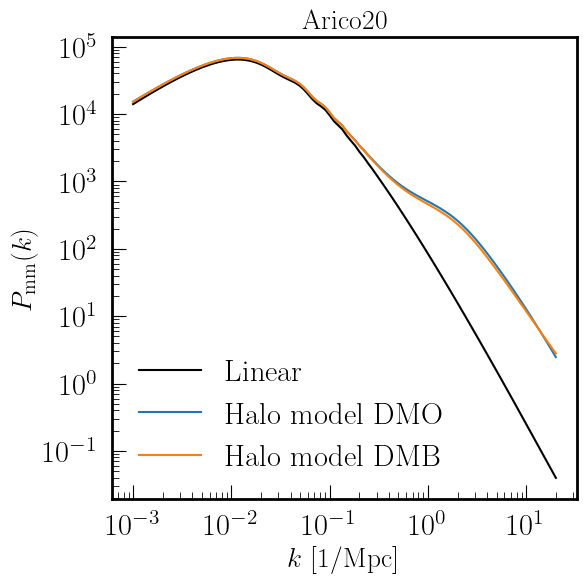

In [15]:
plt.figure(figsize = (6,6))
plt.loglog()

#The DMB P(k) is slightly higher than DMO one even on large scales.
#This is because of a gas normalization subtlety between the Arico20 model
#and the Arico24 tSZ version, that I have not fully sorted out.
plt.plot(k, P_mm_lin, color = 'k', label = 'Linear')
plt.plot(k, P_mm_dmo, label = 'Halo model DMO')
plt.plot(k, P_mm_bar, label = 'Halo model DMB')

plt.xlabel(r'$k$ [1/Mpc]', size = 20)
plt.ylabel(r'$P_{\rm mm}(k)$', size = 20)
plt.title(r'Arico20', size = 20)
plt.tick_params(pad = 10)
plt.legend()
plt.show()

# Now plot everything together

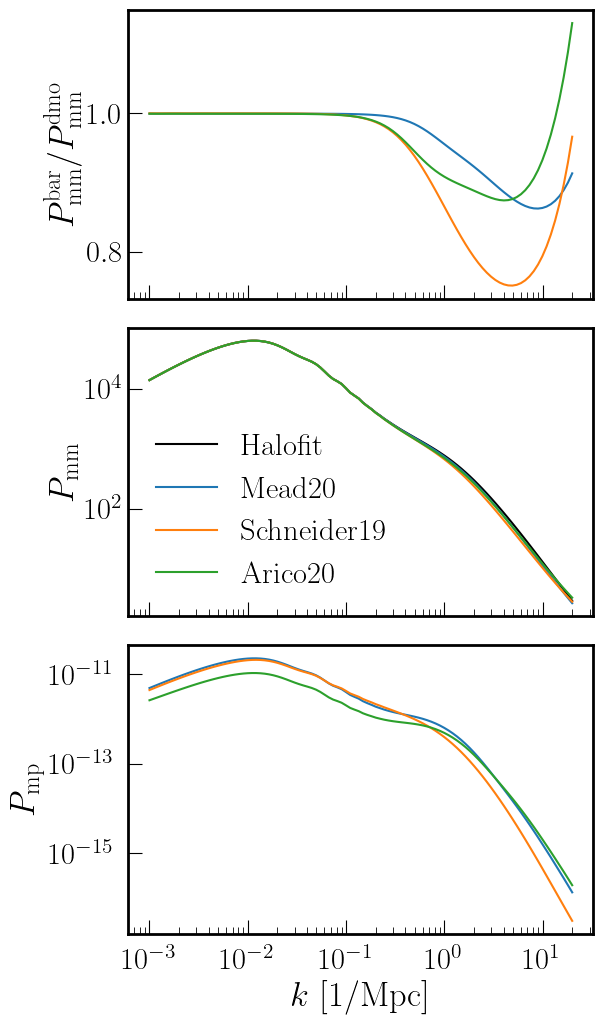

In [16]:
fig, ax = plt.subplots(3, 1, figsize = (6, 12), sharex = True)
plt.subplots_adjust(hspace = 0.1)
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

cosmo_tmp = ccl.Cosmology(Omega_c = 0.26, Omega_b = 0.04, h = 0.7, sigma8 = 0.8, n_s = 0.96, matter_power_spectrum='halofit')
cosmo_tmp.compute_nonlin_power()
Pk_NL = cosmo_tmp.nonlin_matter_power(k, a)

ax[1].plot(k, Pk_NL, color = 'k', label = 'Halofit')
for key in R_mm.keys():
    ax[1].plot(k, Pk_NL * R_mm[key], label = key)
    ax[0].plot(k, R_mm[key], label = key)
    ax[2].plot(k, Pk_NL * R_mp[key], label = key)
    
ax[1].legend()
ax[0].set_ylabel(r'$P^{\rm bar}_{\rm mm} / P^{\rm dmo}_{\rm mm}$', size = 25)
ax[1].set_ylabel(r'$P_{\rm mm}$', size = 25)
ax[2].set_ylabel(r'$P_{\rm mp}$', size = 25)
ax[2].set_xlabel(r'$k$ [1/Mpc]',  size = 25)
ax[2].tick_params(pad = 10)